In [1]:
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 2 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 41.91 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
# Install libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf pytorch-lightning
!pip uninstall torchtext --yes
!pip install einops
# !pip install git+https://github.com/openai/CLIP.git
# !pip install git+https://github.com/CompVis/taming-transformers.git
# !pip install omegaconf==2.0.0 pytorch-lightning==1.0.0 torch==1.13.1 torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 949.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 36.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=4161710913fd950bb7ccac445520799c8f8aa489e3537745170c47cd48fcfa30
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 973.1 kB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
from CLIP import clip

# remove warnings from code

# import warnings
# warnings.filterwarnings('ignore')

In [4]:
# Utils

# Show image from tensor format
def img_from_tensor(tensor):
  img=tensor.clone()
  img=img.mul(255).byte()
  img=img.cpu().numpy().transpose((1,2,0))
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def normalize_data(data):
  return(data.clip(-1, 1) + 1)/2

# Hyperparams
learning_rate=0.5
batch_size=1
weight_decay=0.1 # regularization param for genralization improvement
noise_factor=0.2 # Improves crop
total_iterations=400 # Usually the more, the better detail (and slower)
img_shape=[600, 600, 3] # [height, width, channels (RGB)]
size_h, size_w, channels = img_shape
device='cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# CLIP Model Block
clip_model, _ = clip.load('ViT-B/32', jit=False) #
clip_model.eval() # it's pre-trained, we just want to generate
print(clip.available_models())
print("Clip model input resolution: ", clip_model.visual.input_resolution)
if device == 'cuda':
  torch.cuda.empty_cache()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 119MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model input resolution:  224


### We will need to resize input images to 224

In [6]:
# Taming Transformers (already trained too)
# %cd taming-transformers/
# %pwd
# !mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
# !mkdir -p models/vqgan_imagenet_f16_16384/configs

# if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  # download models
  # !wget 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  # !wget 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

In [8]:
%cd taming-transformers/
from taming.models.vqgan import VQModel

def load_config(path, display=False):
  conf_data=OmegaConf.load(path)
  if display:
    print(yaml.dump(OmegaConf.to_container(conf_data)))
  return conf_data

def load_vqgan(config, checkpoint_path=None):
  model=VQModel(**config.model.params)
  if checkpoint_path is not None:
    state_dict = torch.load(checkpoint_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_conf = load_config("/content/drive/MyDrive/CLIP_Taming/model.yaml", display=True)
taming_model = load_vqgan(taming_conf, checkpoint_path="/content/drive/MyDrive/CLIP_Taming/last.ckpt").to(device)

[Errno 2] No such file or directory: 'taming-transformers/'
/content/taming-transformers
model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 113MB/s]


8.19kB [00:00, 356kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [9]:
# Declare values to be optimized
class Params(torch.nn.Module):
  def __init__(self):
    super(Params, self).__init__()
    self.data=0.5*torch.randn(batch_size, 256, size_h//16, size_w).cuda() # 256 channels due to arch constraints
    self.data=torch.nn.Parameter(torch.sin(self.data)) # for positional embedding

  def forward(self):
    return self.data

def init_params():
  params=Params().cuda()
  optimizer=torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=weight_decay)
  return params, optimizer

torch.Size([1, 256, 37, 600])
image dimensions -->  torch.Size([1, 3, 592, 9600])


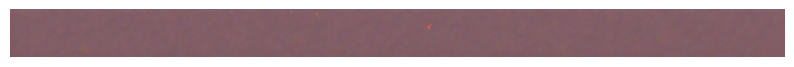

In [10]:
# Encoding prompts
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
def encode_text(text):
  tokenized = clip.tokenize(text).cuda()
  tokenized=clip_model.encode_text(tokenized).detach().clone()
  return tokenized

def create_encodings(include, exclude, extras): # things to be in the pic, things to omit in the pic, characteristics to add to included things
  include_encodings=[]
  for text in include:
    include_encodings.append(encode_text(text))
  exclude_encodings=encode_text(exclude) if exclude != '' else 0
  extras_encodings=encode_text(extras) if extras != '' else 0
  return include_encodings, exclude_encodings, extras_encodings

augmentation_transform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (0.2, 0.2), fill=0)
).cuda()

Params, optimizer = init_params()

# Test
with torch.no_grad():
  print(Params().shape)
  image = normalize_data(generator(Params()).cpu())
  print("image dimensions --> ", image.shape)
  img_from_tensor(image[0])

In [11]:
# Crops
def make_crops(image, n_crops=30):
  p=size_h // 2
  image = torch.nn.functional.grad(image, (p,p,p), mode='constant', value=0)
  image = augmentation_transform(image)
  crop_set = []
  for c in range(n_crops):
    gap_1 = int(torch.normal(1.3, 0.3, ()).clip(0.37, 1.95) * size_h)
    gap_2 = int(torch.normal(1.2, 0.5, ()).clip(0.29, 1.61) * size_h)

    offset_x = torch.randint(0, int(size_h*2 - gap_1), ())
    offset_y = torch.randint(0, int(size_h*2 - gap_1), ())

    crop=image[:, :, offset_x:offset_x+gap_2, offset_y:offset_y+gap_2]
    crop = torch.nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_content=True)
    crop_set.append(crop)

  image_crop = torch.cat(crop_set, 0)
  randnormal = torch.randn_like(image_crop, requires_grad=False)
  n_rands=2
  rands_total = torch.rand((image_crop.shape[0], 1, 1, 1)).cuda()

  for n in range(n_rands):
    rands_total*=torch.rand((image_crop.shae[0],1,1,1)).cuda()

  image_crop = image_crop + noise_factor * rands_total*randnormal
  return image_crop

In [12]:
# show current state
def show_state(Params, show_crop):
  generated = generator(Params())
  if(show_crop):
    print("Augmented crop example")
    augmented_generated = generated.float()
    autmented_generated = make_crops(augmented_generated, n_crops=1)
    augmented_gen_normalized=normalize_data(augmented_generated[0])
    img_from_tensor(augmented_gen_normalized)

  print("Generate")
  latest_generated=normalize_data(generated.cpu())
  img_from_tensor(latest_generated[0])

  return(latest_generated[0])

In [13]:
# Optimization
def optimize_result(Params, prompt):
  alpha=1 # weight of included encodings
  beta=0.5 # weight of excluded encodings

  # Image encoding
  output = generator(Params)
  output = normalize_data(output)
  output = make_crops(output)
  output = normalize(output)
  image_encodings = clip_model.encode_image(output)

  # Text encoding
  encoding = weight_1*prompt + weight_2*extras_encodings
  text_included_encodings = encoding / encoding.normalize(dim=-1, keepdim=True)
  text_excluded_encodings = excluded_encodings

  # Loss Calc
  main_loss = torch.cosine_similarity(text_included_encodings, image_encodings, -1)
  penalize_loss = torch.cosine_similarity(text_excluded_encodings, image_encodings, -1)
  total_loss = -alpha*main_loss + beta*penalize_loss

  return total_loss


def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [14]:
# Training loop
def training_loop(Params, optimizer, show_crop=False):
  result_images=[]
  result_z = []

  for prompt in included_encodings:
    iteration=0
    Params, optimizer = init_params()

    for iteration in range(total_iterations):
      loss = optimize(Params, optimizer, prompt)
      if iteration > 0 and iteration % (total_iterations - 1) == 0:
        new_image = show_state(Params, show_crop)
        result_images.apped(new_image)
        result_z.append(Params())
        print("Loss: ", loss.item(), "\niteration:", iteration)

      iteration += 1
    torch.cuda.empty_cache()
  return result_images, result_z

In [15]:
torch.cuda.empty_cache()
included_text=["sketch of a woman with an umbrella", "sketch of a man with a hat"]
excluded_text="watermark, cropped, confusing, blurry"
extras = "watercolor paper texture"
weight_1 = 1
weight_2 = 1

included_encodings, excluded_encodings, extras_encodings = create_encodings(included_text, excluded_text, extras)
result_image, result_z = training_loop(Params, optimizer, show_crop=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 348.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 207.06 MiB is free. Process 2817 has 14.54 GiB memory in use. Of the allocated memory 13.75 GiB is allocated by PyTorch, and 675.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(len(result_image), len(result_z))
print(result_image[0].shape, result_z[0].shape)
print(result_z[0].max(), result_z[0].min())

In [ ]:
def interpolate(result_z_list, duration_list):
  generated_img_list=[]
  fps=25

  for i, (z, duration) in enumerate(zip(result_z_list, duration_list)):
    n_steps = int(duration*fps)
    z0=z
    z1=result_z_list[(i+1)%len(result_z_list)]

    for step in range(n_steps):
      alpha = math.sin(1.5*step/n_steps)**3
      z_new = alpha*z1 + (1 - alpha) * z0

      new_generated=normalize_data(generator(z_new).cpu())[0]
      new_image = T.toPILImage(mode='RGB')(new_generated)
      generated_img_list.append(new_image)

  return generated_img_list

  durations=[3,3,3,3,3,3]
  interpolated_result = interpolate(result_z, durations)

In [ ]:
# Making of a Video
output_video_path=f"/content/result.mp4"
writer = imageio.get_writer(output_video_path, fps=25)
for pil_img in interpolated_result:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("/content/result.mp4", "rb").read()
data = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)